*Accompanying code examples of the book "Introduction to Artificial Neural Networks and Deep Learning: A Practical Guide with Applications in Python" by [Sebastian Raschka](https://sebastianraschka.com). All code examples are released under the [MIT license](https://github.com/rasbt/deep-learning-book/blob/master/LICENSE). If you find this content useful, please consider supporting the work by buying a [copy of the book](https://leanpub.com/ann-and-deeplearning).*
  
Other code examples and content are available on [GitHub](https://github.com/rasbt/deep-learning-book). The PDF and ebook versions of the book are available through [Leanpub](https://leanpub.com/ann-and-deeplearning).

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p tensorflow

Sebastian Raschka 

CPython 3.6.1
IPython 6.0.0

tensorflow 1.2.0


# Model Zoo -- Convolutional Autoencoder with Deconvolutions

A convolutional autoencoder using deconvolutional layers that compresses 768-pixel MNIST images down to a 7x7x4 (196 pixel) representation.

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data


##########################
### DATASET
##########################

mnist = input_data.read_data_sets("./", validation_size=0)


##########################
### SETTINGS
##########################

# Hyperparameters
learning_rate = 0.001
training_epochs = 5
batch_size = 128

# Architecture
hidden_size = 16
input_size = 784
image_width = 28

# Other
print_interval = 200
random_seed = 123


##########################
### GRAPH DEFINITION
##########################

g = tf.Graph()
with g.as_default():
    
    tf.set_random_seed(random_seed)

    # Input data
    tf_x = tf.placeholder(tf.float32, [None, input_size], name='inputs')
    input_layer = tf.reshape(tf_x, shape=[-1, image_width, image_width, 1])

    ###########
    # Encoder
    ###########
    
    # 28x28x1 => 28x28x8
    conv1 = tf.layers.conv2d(input_layer, filters=8, kernel_size=(3, 3),
                             strides=(1, 1), padding='same', 
                             activation=tf.nn.relu)
    # 28x28x8 => 14x14x8
    maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=(2, 2), 
                                       strides=(2, 2), padding='same')
    
    # 14x14x8 => 14x14x4
    conv2 = tf.layers.conv2d(maxpool1, filters=4, kernel_size=(3, 3), 
                             strides=(1, 1), padding='same', 
                             activation=tf.nn.relu)
    
    # 14x14x4 => 7x7x4
    encode = tf.layers.max_pooling2d(conv2, pool_size=(2, 2), 
                                     strides=(2, 2), padding='same', 
                                     name='encoding')

    ###########
    # Decoder
    ###########
    
    # 7x7x4 => 14x14x8
    deconv1 = tf.layers.conv2d_transpose(encode, filters=8, 
                                         kernel_size=(3, 3), strides=(2, 2), 
                                         padding='same',
                                         activation=tf.nn.relu)
    
    
    # 14x14x8 => 28x28x8
    deconv2 = tf.layers.conv2d_transpose(deconv1, filters=8, 
                                         kernel_size=(3, 3), strides=(2, 2), 
                                         padding='same',
                                         activation=tf.nn.relu)
    
    # 28x28x8 => 28x28x1
    logits = tf.layers.conv2d(deconv2, filters=1, kernel_size=(3,3), 
                              strides=(1, 1), padding='same', 
                              activation=None)
    
    decode = tf.nn.sigmoid(logits, name='decoding')

    ##################
    # Loss & Optimizer
    ##################
    
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=input_layer,
                                                   logits=logits)
    cost = tf.reduce_mean(loss, name='cost')
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(cost, name='train')    

    # Saver to save session for reuse
    saver = tf.train.Saver()

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [3]:
import numpy as np

##########################
### TRAINING & EVALUATION
##########################
    
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())

    np.random.seed(random_seed) # random seed for mnist iterator
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = mnist.train.num_examples // batch_size

        for i in range(total_batch):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            _, c = sess.run(['train', 'cost:0'], feed_dict={'inputs:0': batch_x})

            avg_cost += c

            if not i % print_interval:
                print("Minibatch: %03d | Cost:    %.3f" % (i + 1, c))

        print("Epoch:     %03d | AvgCost: %.3f" % (epoch + 1, avg_cost / (i + 1)))
    
    saver.save(sess, save_path='./autoencoder.ckpt')

Minibatch: 001 | Cost:    0.693
Minibatch: 201 | Cost:    0.153
Minibatch: 401 | Cost:    0.104
Epoch:     001 | AvgCost: 0.232
Minibatch: 001 | Cost:    0.098
Minibatch: 201 | Cost:    0.096
Minibatch: 401 | Cost:    0.093
Epoch:     002 | AvgCost: 0.093
Minibatch: 001 | Cost:    0.090
Minibatch: 201 | Cost:    0.086
Minibatch: 401 | Cost:    0.089
Epoch:     003 | AvgCost: 0.088
Minibatch: 001 | Cost:    0.086
Minibatch: 201 | Cost:    0.089
Minibatch: 401 | Cost:    0.085
Epoch:     004 | AvgCost: 0.086
Minibatch: 001 | Cost:    0.090
Minibatch: 201 | Cost:    0.083
Minibatch: 401 | Cost:    0.087
Epoch:     005 | AvgCost: 0.084


INFO:tensorflow:Restoring parameters from ./autoencoder.ckpt


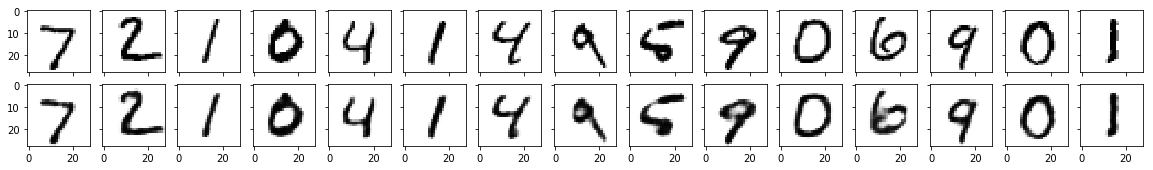

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

##########################
### VISUALIZATION
##########################

n_images = 15

fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, 
                         sharey=True, figsize=(20, 2.5))
test_images = mnist.test.images[:n_images]

with tf.Session(graph=g) as sess:
    saver.restore(sess, save_path='./autoencoder.ckpt')
    decoded = sess.run('decoding:0', feed_dict={'inputs:0': test_images})

for i in range(n_images):
    for ax, img in zip(axes, [test_images, decoded]):
        ax[i].imshow(img[i].reshape((image_width, image_width)), cmap='binary')